# 젠더 폭력 관련 법안 LDA 


## 환경설정

In [2]:
!pip3 install konlpy 
!pip3 install pyLDAvis
!pip3 install -U gensim

     |████████████████████████████████| 19.4MB 62.7MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
     |████████████████████████████████| 3.8MB 41.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 1.6MB 4.4MB/s 
     |████████████████████████████████| 552kB 19.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=0e35cad06cb6fd430fd511f15574d178d0cc0576129312992278b5b4f370beea
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=8ce84e90f415cec901e8ec94b057cd3cf3f9a50c150d97df6e04ef1a0a716c7f
  Stored in directory: /root/.cache/pip/whee

In [2]:
!pip3 install pyLDAvis

     |████████████████████████████████| 1.6 MB 533 kB/s eta 0:00:01
     |████████████████████████████████| 101 kB 3.9 MB/s ta 0:00:011
     |████████████████████████████████| 270 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 548 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 2.8 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=752a8056f185cd2e5690d737d28076f86603ec15fbc26752aa6ba4826fe2fe26
  Stored in directory: /Users/harampark/Library/Caches/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=5fde4558ec3ddb1508143a7a7a7687471bb6d1a756a379970d129e7ad66771d9
  Stored in directory: /Users/harampark/Library/Caches/pip/wheels/8e/70/28/3d6ccd6e315f65f

In [3]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
import time
import datetime

from gensim.models import word2vec
from konlpy.tag import Okt
%matplotlib inline

from string import punctuation

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import collections
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [5]:
plt.rc('font', family='NanumBarunGothic')

## 1. 데이터 로드 및 확인

In [39]:
bill_df = pd.read_csv('2021-bill-preprocessed.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자','의결처리기간'] )
print(bill_df.shape)
bill_df.columns

(26140, 39)


Index(['의안번호', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '제안회기', '제안이유', '소관위원회',
       '제안정당', '법률반영여부', '법률안', 'Unnamed: 13', '개혁보수신당', '국민의당', '기본소득당',
       '대안신당', '대한애국당', '더불어민주당', '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당',
       '미래한국당', '민생당', '민주평화당', '민중당', '바른미래당', '바른정당', '새누리당', '새로운보수당',
       '새민중정당', '시대전환', '열린민주당', '우리공화당', '자유한국당', '정의당', '의결처리기간', '법률공포여부'],
      dtype='object')

In [40]:
bill_df.drop('Unnamed: 13',1, inplace=True)

## 2. 젠더 폭력 관련 의안 추출

In [202]:
# 한글 전처리
def preprocessing(text): 
    text = re.sub('\\\\n', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return str(text)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
             '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [173]:
# 의안번호 2014046 2018년 먼저 다크웹 규제 강화 법안 발의 but 임기만료폐기 
keyword = r'.*(N번방|n번방|불법촬영|스토킹|데이트폭력|데이트 폭력|디지털성범죄|사이버범죄|포르노|\
                카르텔|과다노출|사이버 범죄|몰래카메라|몰카|불법 촬영|몸캠|성폭력|성착취|성매매|성범죄|\
                버닝썬|성희롱|딥페이크|복제물|음란|성범죄|n번방|웹하드|촬영물|클럽|성접대|미투|그루밍|성희롱).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1016, 38)

In [179]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()

In [180]:
gender['의안텍스트'] = gender['의안텍스트'].apply(str)

In [181]:
%time contents = gender['의안텍스트'].apply(preprocessing)

CPU times: user 56.4 ms, sys: 3.95 ms, total: 60.3 ms
Wall time: 59.9 ms


In [182]:
# 단어에서 명사만 뽑아내기
okt = Okt()
%time tokens = contents.apply(okt.nouns)
tokens[:3]

CPU times: user 35 s, sys: 505 ms, total: 35.5 s
Wall time: 36 s


0    [아동, 청소년, 보호, 관, 법률, 일부, 개정, 법률, 안, 대안, 아동, 청소...
1    [정보통신망, 이용, 촉진, 및, 정보보호, 등, 관, 법률, 일부, 개정, 법률,...
2    [전기통신사업법, 일부, 개정, 법률, 안, 대안, 일부, 기간, 통신사, 업자, ...
Name: 의안텍스트, dtype: object

In [183]:
%time tokens_clean = tokens.apply(remove_stopword)

CPU times: user 308 ms, sys: 3.88 ms, total: 312 ms
Wall time: 312 ms


In [184]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [185]:
# 모델 학습
model = word2vec.Word2Vec(tokens_clean, size=100, window=10, workers=4, 
                          min_count=10, iter=30, sg=0)
model

2020-08-31 20:48:18,298 : INFO : collecting all words and their counts
2020-08-31 20:48:18,300 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-31 20:48:18,331 : INFO : collected 5102 word types from a corpus of 117860 raw words and 1016 sentences
2020-08-31 20:48:18,333 : INFO : Loading a fresh vocabulary
2020-08-31 20:48:18,346 : INFO : effective_min_count=10 retains 1578 unique words (30% of original 5102, drops 3524)
2020-08-31 20:48:18,347 : INFO : effective_min_count=10 leaves 107552 word corpus (91% of original 117860, drops 10308)
2020-08-31 20:48:18,352 : INFO : deleting the raw counts dictionary of 5102 items
2020-08-31 20:48:18,355 : INFO : sample=0.001 downsamples 62 most-common words
2020-08-31 20:48:18,356 : INFO : downsampling leaves estimated 90697 word corpus (84.3% of prior 107552)
2020-08-31 20:48:18,367 : INFO : estimated required memory for 1578 words and 100 dimensions: 2051400 bytes
2020-08-31 20:48:18,368 : INFO : resetting laye

2020-08-31 20:48:19,883 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 20:48:19,888 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 20:48:19,891 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 20:48:19,891 : INFO : EPOCH - 15 : training on 117860 raw words (90668 effective words) took 0.1s, 1251804 effective words/s
2020-08-31 20:48:19,954 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-31 20:48:19,961 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-31 20:48:19,963 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-31 20:48:19,965 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-31 20:48:19,967 : INFO : EPOCH - 16 : training on 117860 raw words (90684 effective words) took 0.1s, 1300884 effective words/s
2020-08-31 20:48:20,043 : INFO : worker thread finished; awaiting finish of 3 more threads


In [186]:
# 모델 이름을 지정하고 저장한다.
model_name = 'genderWords'
model.save(model_name)

2020-08-31 20:48:37,771 : INFO : saving Word2Vec object under genderWords, separately None
2020-08-31 20:48:37,774 : INFO : not storing attribute vectors_norm
2020-08-31 20:48:37,776 : INFO : not storing attribute cum_table
2020-08-31 20:48:37,803 : INFO : saved genderWords


In [187]:
len(model.wv.vocab)

1578

In [188]:
vocab = model.wv.vocab

In [191]:
vocab = model.wv.vocab
print(model.wv.most_similar('디지털'))
print(model.wv.most_similar('청소년'))

[('물의', 0.6139096021652222), ('번방', 0.6027237176895142), ('급증', 0.5939536094665527), ('불법', 0.5938412547111511), ('유포', 0.5675835609436035), ('모니터링', 0.5661501884460449), ('비디오', 0.5627310872077942), ('웹하드', 0.5494408011436462), ('야기', 0.5416814684867859), ('사진', 0.5351071953773499)]
[('아동', 0.7118347883224487), ('음란물', 0.5586869716644287), ('대상', 0.5066319108009338), ('유인', 0.4800465703010559), ('그루밍', 0.46212923526763916), ('허용', 0.46099036931991577), ('제작', 0.4552733600139618), ('성인', 0.438437283039093), ('로부터', 0.4276725649833679), ('보육', 0.4143850803375244)]


## 법안 토픽 모델링

In [192]:
stopword_list = ['법률', '경우', '대한', '일부', '개정','것임', '관련','현행법','위원회','조의','국회법',\
                  '조제', '관련', '내용', '사항', '발생', '행위', '운영', '업무','이상', '신설', '규정',\
                  '해당', '기준', '마련', '설치', '사항', '대상', '또는', '있음', '대해', '대하', '거나']

In [193]:
           
###################### 텍스트전처리 ######################

def Preproc(textlist):

    ## 특수문자 제거 & 명사추출
    okt = Okt()
    cleanlist = []
    nounlist = []
    removedict = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음']
        
    for i in range(len(textlist)):
        n = re.sub('[-=.#/:$}·,■?]','',str(textlist[i]))
        k = re.sub('[0-9]','',n)
        nounlist.append(okt.nouns(k))
    
    for i in nounlist:
        for j in i:
            if len(j)==1:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in removedict:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in stopword_list:
                i.remove(j)

    cleanlist = nounlist
    
    return cleanlist

###################### 상위 50개 단어 제거 ######################


def remove_common(cleanlist):
    collections.Counter()

    flat=[]
    for i in cleanlist:
        for j in i:
            if (j not in stopword_list) or (len(j)!=1):
                flat.append(j)
                    
                    
    commoncount = collections.Counter(flat)
    commoncount = commoncount.most_common(50)

    newdict = []

    for i in range(len(commoncount)): #50
        newdict.append(commoncount[i][0])
 
    for i in cleanlist:
        if i in newdict:
            cleanlist.remove(i)
    
    return cleanlist, newdict

###################### 말뭉치 ######################

def make_corpus(cleanlist):

    dictionary = corpora.Dictionary(cleanlist)
    corpus = [dictionary.doc2bow(text) for text in cleanlist]
    
    return corpus, dictionary, cleanlist

###################### 토픽수최적화 ######################

def coh_visual(corpus, dictionary, cleanlist):
    
    coherence_values = []
    
    for i in range(2,20):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
    
    x = range(2,20)
    plt.plot(x, coherence_values)
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    plt.show()
      
###################### 언어모델평가 ######################

def perp_visual(corpus, dictionary):
    
    perplexity_values = []
    
    for i in range(2,20):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        perplexity_values.append(ldamodel.log_perplexity(corpus))
    
    x = range(2,20)
    plt.plot(x, perplexity_values)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity score')
    plt.show()

In [198]:
# 젠더 법안 하나의 리스트로! 
gender_text_list = []
for i in gender['의안텍스트']:
    gender_text_list.append(i)

2020-08-31 20:52:41,376 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 20:52:41,481 : INFO : built Dictionary(5028 unique tokens: ['각심', '갈수록', '강간', '강제추행', '개정']...) from 1016 documents (total 107259 corpus positions)
2020-08-31 20:52:41,547 : INFO : using symmetric alpha at 0.5
2020-08-31 20:52:41,548 : INFO : using symmetric eta at 0.5
2020-08-31 20:52:41,549 : INFO : using serial LDA version on this node
2020-08-31 20:52:41,553 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:52:41,554 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:52:42,615 : INFO : -8.939 per-word bound, 491.0 perplexity estimate based on a held-out corpus of 1016 docume

2020-08-31 20:52:52,530 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:52:53,672 : INFO : -9.219 per-word bound, 596.0 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:52:53,673 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:52:54,563 : INFO : topic #0 (0.200): 0.024*"범죄" + 0.020*"성폭력" + 0.018*"피해자" + 0.017*"제조" + 0.013*"성희롱" + 0.011*"처벌" + 0.011*"피해" + 0.011*"교육" + 0.009*"안" + 0.009*"보호"
2020-08-31 20:52:54,563 : INFO : topic #1 (0.200): 0.019*"제조" + 0.016*"성폭력" + 0.013*"기관" + 0.013*"범죄" + 0.011*"성범죄" + 0.010*"청소년" + 0.009*"보호" + 0.008*"개정" + 0.008*"피해자" + 0.007*"처벌"
2020-08-31 20:52:54,565 : INFO : topic #2 (0.200): 0.021*"제조" + 0.013*"보호" + 0.012*"성폭력" + 0.011*"범죄" + 0.010*"개정" + 0.009*"피해자" + 0.009*"촬영" + 0.008*"안" + 0.008*"처벌" + 0.008*"조치"
2020-08-31 20:52:54,567 : INFO : topic #3 (0.200): 0.022*"제조" + 0.020*"범죄" + 0.0

2020-08-31 20:53:03,032 : INFO : accumulated word occurrence stats for 22589 virtual documents
2020-08-31 20:53:03,131 : INFO : using symmetric alpha at 0.125
2020-08-31 20:53:03,132 : INFO : using symmetric eta at 0.125
2020-08-31 20:53:03,133 : INFO : using serial LDA version on this node
2020-08-31 20:53:03,141 : INFO : running online (single-pass) LDA training, 8 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:53:03,142 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:53:04,300 : INFO : -9.479 per-word bound, 713.8 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:53:04,301 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:53:05,164 : INFO : topic #0 (0.125): 0

2020-08-31 20:53:13,303 : INFO : 12 batches submitted to accumulate stats from 768 documents (-4137 virtual)
2020-08-31 20:53:13,314 : INFO : 13 batches submitted to accumulate stats from 832 documents (-4120 virtual)
2020-08-31 20:53:13,337 : INFO : 14 batches submitted to accumulate stats from 896 documents (-3446 virtual)
2020-08-31 20:53:13,359 : INFO : 15 batches submitted to accumulate stats from 960 documents (-3265 virtual)
2020-08-31 20:53:13,523 : INFO : 3 accumulators retrieved from output queue
2020-08-31 20:53:13,529 : INFO : accumulated word occurrence stats for 22589 virtual documents
2020-08-31 20:53:13,643 : INFO : using symmetric alpha at 0.09090909090909091
2020-08-31 20:53:13,644 : INFO : using symmetric eta at 0.09090909090909091
2020-08-31 20:53:13,645 : INFO : using serial LDA version on this node
2020-08-31 20:53:13,653 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 10

2020-08-31 20:53:23,025 : INFO : topic diff=6.243527, rho=1.000000
2020-08-31 20:53:23,030 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-08-31 20:53:23,262 : INFO : 1 batches submitted to accumulate stats from 64 documents (355 virtual)
2020-08-31 20:53:24,066 : INFO : 4 batches submitted to accumulate stats from 256 documents (-963 virtual)
2020-08-31 20:53:24,242 : INFO : 11 batches submitted to accumulate stats from 704 documents (-4488 virtual)
2020-08-31 20:53:24,253 : INFO : 12 batches submitted to accumulate stats from 768 documents (-4137 virtual)
2020-08-31 20:53:24,269 : INFO : 13 batches submitted to accumulate stats from 832 documents (-4120 virtual)
2020-08-31 20:53:24,278 : INFO : 14 batches submitted to accumulate stats from 896 documents (-3446 virtual)
2020-08-31 20:53:24,317 : INFO : 15 batches submitted to accumulate stats from 960 documents (-3265 virtual)
2020-08-31 20:53:24,478 : IN

2020-08-31 20:53:34,706 : INFO : topic #12 (0.062): 0.017*"청소년" + 0.015*"제조" + 0.010*"범죄" + 0.009*"성범죄" + 0.009*"아동" + 0.008*"피해자" + 0.007*"성매매" + 0.007*"사람" + 0.007*"안" + 0.006*"처벌"
2020-08-31 20:53:34,707 : INFO : topic #0 (0.062): 0.040*"성폭력" + 0.024*"범죄" + 0.020*"처벌" + 0.020*"제조" + 0.014*"피해자" + 0.011*"개정" + 0.010*"관" + 0.008*"청소년" + 0.007*"성범죄" + 0.007*"사회"
2020-08-31 20:53:34,708 : INFO : topic #4 (0.062): 0.022*"제조" + 0.014*"범죄" + 0.013*"성폭력" + 0.012*"피해자" + 0.012*"피해" + 0.012*"방범" + 0.010*"자율" + 0.009*"안" + 0.009*"보호" + 0.009*"개정"
2020-08-31 20:53:34,709 : INFO : topic diff=7.981477, rho=1.000000
2020-08-31 20:53:34,713 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-08-31 20:53:34,925 : INFO : 1 batches submitted to accumulate stats from 64 documents (355 virtual)
2020-08-31 20:53:35,656 : INFO : 4 batches submitted to accumulate stats from 256 documents (-963 virtual)
2020-08-31 20:53:35,875 : IN

2020-08-31 20:53:45,238 : INFO : -10.624 per-word bound, 1578.5 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:53:45,238 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:53:46,255 : INFO : topic #7 (0.053): 0.020*"촬영" + 0.015*"제조" + 0.014*"제공" + 0.010*"성폭력" + 0.010*"서비스" + 0.009*"처벌" + 0.009*"개정" + 0.009*"신체" + 0.008*"보호" + 0.008*"수련"
2020-08-31 20:53:46,256 : INFO : topic #16 (0.053): 0.017*"범죄" + 0.016*"촬영" + 0.015*"제조" + 0.012*"피해자" + 0.012*"처벌" + 0.011*"보호" + 0.010*"안" + 0.009*"개정" + 0.009*"사람" + 0.008*"고객"
2020-08-31 20:53:46,256 : INFO : topic #9 (0.053): 0.024*"범죄" + 0.018*"아동" + 0.016*"제조" + 0.016*"성폭력" + 0.014*"성희롱" + 0.013*"청소년" + 0.012*"피해자" + 0.012*"보호" + 0.010*"개정" + 0.010*"피해"
2020-08-31 20:53:46,257 : INFO : topic #2 (0.053): 0.022*"공중화장실" + 0.013*"제조" + 0.011*"기관" + 0.009*"범죄" + 0.008*"카메라" + 0.007*"촬영" + 0.007*"안" + 0.007*"몰래카메라" + 0.006*"보호" + 0.005*"교원"
2020-08-31 20:53:46,258 : INFO : topic #4 (0.053):

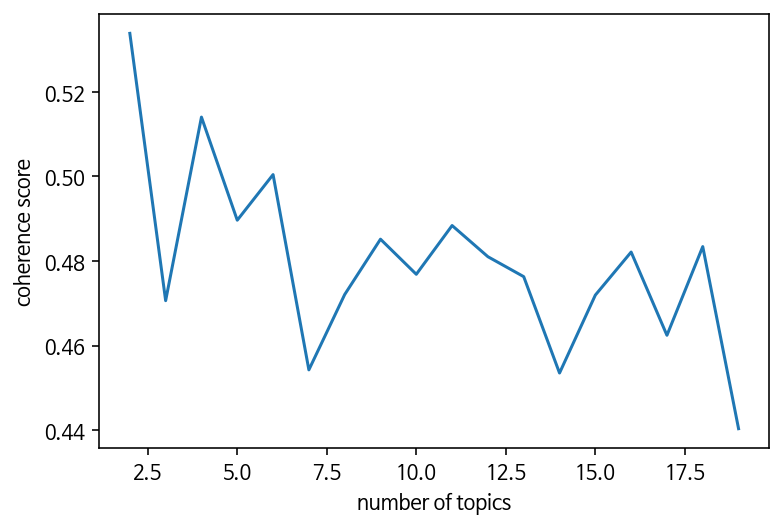

In [199]:
gender_clean = Preproc(gender_text_list)
gender_corpus, gender_dictionary, gender_cleanlist = make_corpus(gender_clean)
coh_visual(gender_corpus, gender_dictionary, gender_cleanlist)

2020-08-31 20:54:02,383 : INFO : using symmetric alpha at 0.5
2020-08-31 20:54:02,385 : INFO : using symmetric eta at 0.5
2020-08-31 20:54:02,388 : INFO : using serial LDA version on this node
2020-08-31 20:54:02,392 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:54:02,393 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:54:03,553 : INFO : -8.945 per-word bound, 492.9 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:54:03,554 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:54:04,443 : INFO : topic #0 (0.500): 0.019*"범죄" + 0.018*"제조" + 0.015*"성폭력" + 0.011*"아동" + 0.011*"청소년" + 0.010*"보호" + 0.009*"안" + 0.009*"성

2020-08-31 20:54:17,014 : INFO : topic #1 (0.167): 0.024*"범죄" + 0.021*"제조" + 0.021*"성폭력" + 0.017*"피해자" + 0.016*"처벌" + 0.011*"개정" + 0.010*"성희롱" + 0.009*"보호" + 0.009*"피해" + 0.008*"관"
2020-08-31 20:54:17,015 : INFO : topic #4 (0.167): 0.023*"청소년" + 0.021*"아동" + 0.019*"성폭력" + 0.015*"제조" + 0.015*"범죄" + 0.013*"피해자" + 0.012*"보호" + 0.011*"처벌" + 0.011*"안" + 0.009*"성희롱"
2020-08-31 20:54:17,016 : INFO : topic diff=2.854981, rho=1.000000
2020-08-31 20:54:18,015 : INFO : -7.135 per-word bound, 140.6 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:54:18,016 : INFO : using symmetric alpha at 0.14285714285714285
2020-08-31 20:54:18,016 : INFO : using symmetric eta at 0.14285714285714285
2020-08-31 20:54:18,018 : INFO : using serial LDA version on this node
2020-08-31 20:54:18,024 : INFO : running online (single-pass) LDA training, 7 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexi

2020-08-31 20:54:29,214 : INFO : topic diff=4.712391, rho=1.000000
2020-08-31 20:54:30,347 : INFO : -7.206 per-word bound, 147.6 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:54:30,348 : INFO : using symmetric alpha at 0.09090909090909091
2020-08-31 20:54:30,348 : INFO : using symmetric eta at 0.09090909090909091
2020-08-31 20:54:30,350 : INFO : using serial LDA version on this node
2020-08-31 20:54:30,360 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:54:30,362 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:54:31,601 : INFO : -9.762 per-word bound, 868.1 perplexity estimate based on a held-out corpus of 1016 document

2020-08-31 20:54:43,101 : INFO : using symmetric alpha at 0.06666666666666667
2020-08-31 20:54:43,102 : INFO : using symmetric eta at 0.06666666666666667
2020-08-31 20:54:43,103 : INFO : using serial LDA version on this node
2020-08-31 20:54:43,112 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:54:43,113 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:54:44,223 : INFO : -10.171 per-word bound, 1152.5 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:54:44,223 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:54:45,078 : INFO : topic #10 (0.067): 0.033*"제조" + 0.024*"처벌" + 0.019*"범죄" + 0.014*"성폭력" + 0.014*"촬영" 

2020-08-31 20:54:54,648 : INFO : running online (single-pass) LDA training, 19 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:54:54,649 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:54:55,777 : INFO : -10.625 per-word bound, 1578.8 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:54:55,778 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:54:56,633 : INFO : topic #1 (0.053): 0.038*"성폭력" + 0.025*"피해자" + 0.020*"범죄" + 0.015*"보호" + 0.014*"피해" + 0.012*"처벌" + 0.011*"시효" + 0.010*"사건" + 0.010*"제조" + 0.010*"개정"
2020-08-31 20:54:56,634 : INFO : topic #3 (0.053): 0.025*"체육" + 0.012*"등록" + 0.012*"범죄" + 0.011*"정보" + 0.011*"개정" + 0.011*"이용" + 0.010*"제조" + 0.010*"성폭력" + 0.01

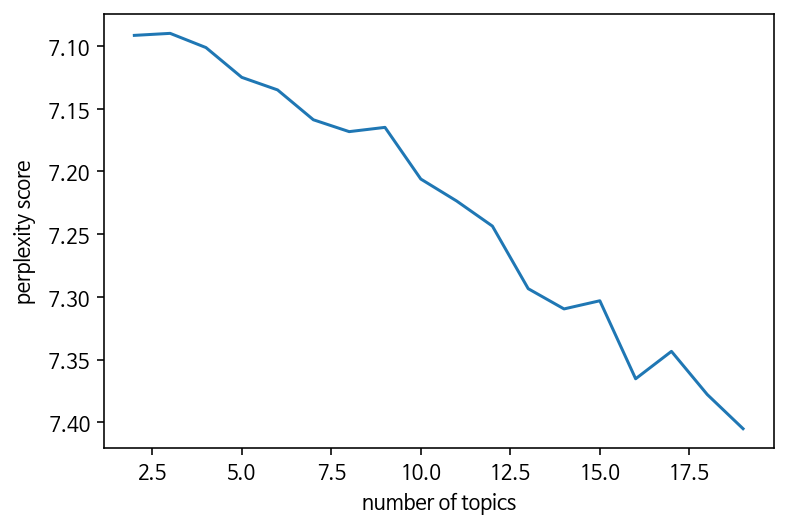

In [200]:
perp_visual(gender_corpus, gender_dictionary)

In [201]:
ldamodel = gensim.models.ldamodel.LdaModel(gender_corpus, num_topics=9, alpha=0.1, id2word = gender_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, gender_corpus, gender_dictionary)
vis

2020-08-31 20:55:27,930 : INFO : using symmetric eta at 0.1111111111111111
2020-08-31 20:55:27,933 : INFO : using serial LDA version on this node
2020-08-31 20:55:27,941 : INFO : running online (single-pass) LDA training, 9 topics, 1 passes over the supplied corpus of 1016 documents, updating model once every 1016 documents, evaluating perplexity every 1016 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 20:55:27,941 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 20:55:29,238 : INFO : -9.571 per-word bound, 760.8 perplexity estimate based on a held-out corpus of 1016 documents with 107259 words
2020-08-31 20:55:29,238 : INFO : PROGRESS: pass 0, at document #1016/1016
2020-08-31 20:55:30,235 : INFO : topic #6 (0.100): 0.023*"청소년" + 0.018*"범죄" + 0.016*"제조" + 0.016*"피해자" + 0.015*"아동" + 0.014*"보호" + 0.013*"성폭력" + 0.013*"성범죄" + 0.010*"피해" + 0.009*"안"
2020-08-31 20:55

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.019579 -0.002097       1        1  15.117170
5     -0.007794 -0.015798       2        1  14.594738
8     -0.038657 -0.018392       3        1  12.264546
6      0.028445  0.032001       4        1  10.776982
1     -0.023471 -0.010497       5        1  10.106414
2      0.011657 -0.003247       6        1   9.628192
7     -0.022774  0.054658       7        1   9.330645
4      0.008819 -0.028813       8        1   9.330052
0      0.063353 -0.007814       9        1   8.851261, topic_info=     Term         Freq        Total Category  logprob  loglift
35     아동  1021.000000  1021.000000  Default  30.0000  30.0000
55    청소년  1092.000000  1092.000000  Default  29.0000  29.0000
158    촬영   496.000000   496.000000  Default  28.0000  28.0000
29    성범죄   770.000000   770.000000  Default  27.0000  27.0000
1280  장애인   287.000000   287.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
143    정보    42.103096   425.223602   Topic9  -5.4183   0.1121
193   성폭력    59.155209  1638.220825   Topic9  -5.0782  -0.8966
33     신고    39.151073   442.284668   Topic9  -5.4910   0.0001
4      개정    44.354694   928.542786   Topic9  -5.3662  -0.6168
150    조치    38.368580   511.730652   Topic9  -5.5112  -0.1659

[739 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2177      1  0.047227   가구
2177      2  0.094453   가구
2177      3  0.141680   가구
2177      4  0.094453   가구
2177      5  0.094453   가구
...     ...       ...  ...
2241      2  0.199269   후기
2241      3  0.597807   후기
2241      4  0.199269   후기
4308      1  0.737168   후속
2687      3  0.486933   흐름

[2398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 9, 7, 2, 3, 8, 5, 1])